Dataset Shape: (100, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   waste_type        100 non-null    object 
 1   moisture_content  100 non-null    float64
 2   pH                100 non-null    float64
 3   temperature       100 non-null    float64
 4   C_N_ratio         100 non-null    float64
 5   time_days         100 non-null    int64  
 6   fertilizer_yield  100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB
None

Missing Values:
waste_type          0
moisture_content    0
pH                  0
temperature         0
C_N_ratio           0
time_days           0
fertilizer_yield    0
dtype: int64

Summary Statistics:
       moisture_content          pH  temperature   C_N_ratio   time_days  \
count        100.000000  100.000000   100.000000  100.000000  100.000000   
mean       

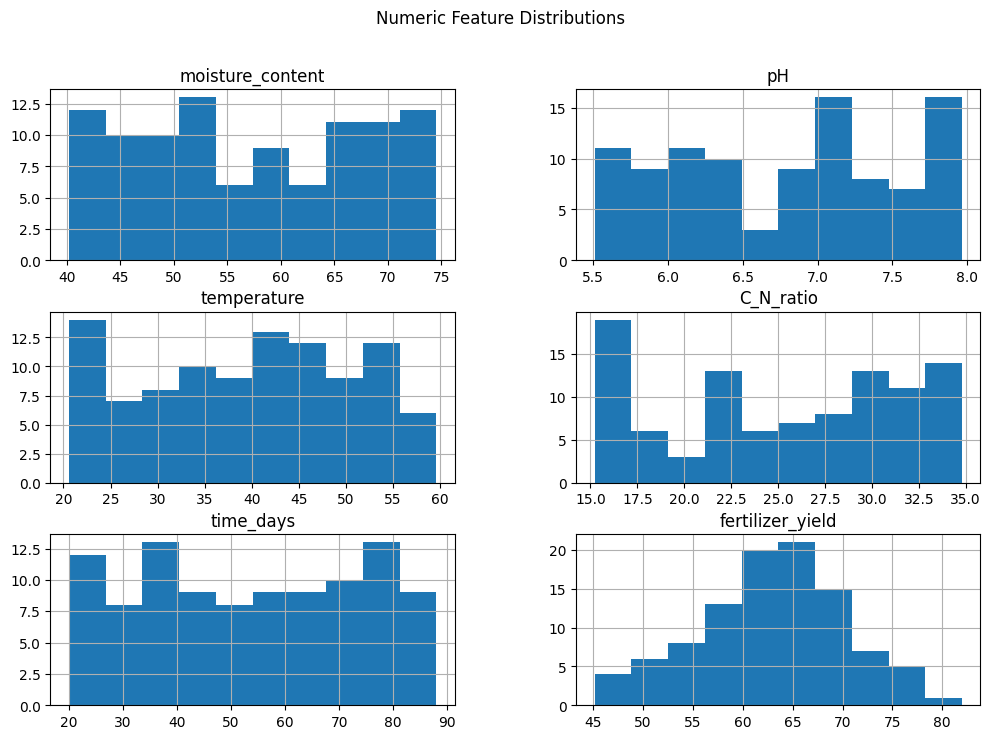

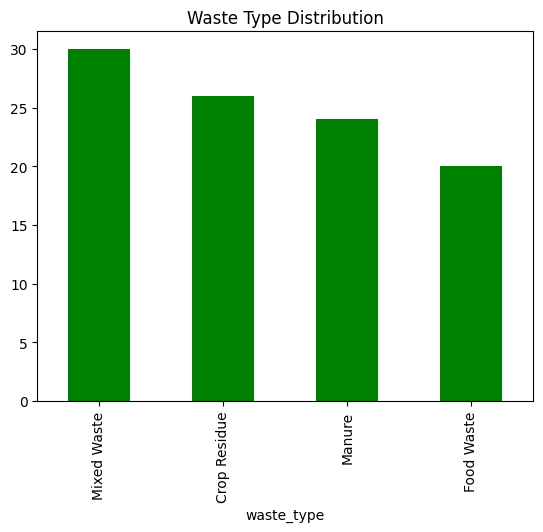

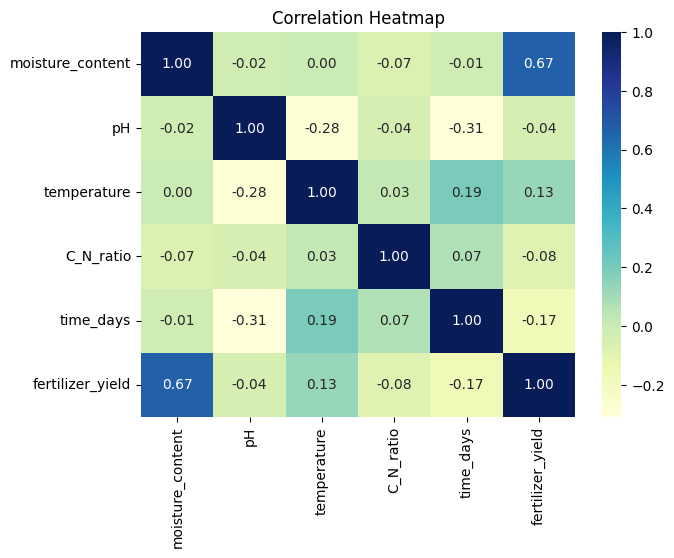


Missing values after imputation:
waste_type          0
moisture_content    0
pH                  0
temperature         0
C_N_ratio           0
time_days           0
fertilizer_yield    0
dtype: int64
Shape before: (100, 7)  | Shape after outlier removal: (100, 7)

Processed Data Shape: (100, 11)

Processed Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   moisture_content           100 non-null    float64
 1   pH                         100 non-null    float64
 2   temperature                100 non-null    float64
 3   C_N_ratio                  100 non-null    float64
 4   time_days                  100 non-null    float64
 5   pH_distance                100 non-null    float64
 6   moisture_temp_interaction  100 non-null    float64
 7   waste_type_Food Waste      100 non-null    float64
 8   waste_type_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv("/content/drive/MyDrive/dataset/organic_waste_fertilizer_raw.csv")

print("Dataset Shape:", df.shape)
df.head()

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isna().sum())

print("\nSummary Statistics:")
print(df.describe())

df[['moisture_content','pH','temperature','C_N_ratio','time_days','fertilizer_yield']].hist(figsize=(12,8))
plt.suptitle("Numeric Feature Distributions")
plt.show()

df['waste_type'].value_counts().plot(kind='bar', color='green')
plt.title("Waste Type Distribution")
plt.show()


plt.figure(figsize=(7,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

num_cols = ['moisture_content','pH','temperature','C_N_ratio','time_days','fertilizer_yield']
cat_cols = ['waste_type']

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print("\nMissing values after imputation:")
print(df.isna().sum())

def remove_outliers_iqr(data, columns):
    df_clean = data.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        mask = ~((df_clean[col] < (Q1 - 1.5*IQR)) | (df_clean[col] > (Q3 + 1.5*IQR)))
        df_clean = df_clean[mask]
    return df_clean

df_clean = remove_outliers_iqr(df, num_cols[:-1])  # exclude target if you want
print("Shape before:", df.shape, " | Shape after outlier removal:", df_clean.shape)

df_clean['pH_distance'] = (df_clean['pH'] - 6.8).abs()
df_clean['moisture_temp_interaction'] = df_clean['moisture_content'] * df_clean['temperature']

df_clean.head()

num_features = ['moisture_content','pH','temperature','C_N_ratio','time_days','pH_distance','moisture_temp_interaction']
cat_features = ['waste_type']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)
])


X = df_clean.drop(columns=['fertilizer_yield'])
y = df_clean['fertilizer_yield'].reset_index(drop=True)

X_processed = preprocessor.fit_transform(X)

cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
feature_names = num_features + list(cat_names)

X_proc_df = pd.DataFrame(X_processed, columns=feature_names)
X_proc_df['fertilizer_yield'] = y.reset_index(drop=True)

print("\nProcessed Data Shape:", X_proc_df.shape)
print("\nProcessed Data Info:")
print(X_proc_df.info())
print("\nFirst 5 rows of pre processed data: ")
print(X_proc_df.head())

X_proc_df.to_csv("organic_waste_fertilizer_preprocessed.csv", index=False)
print("\n✅ Preprocessed dataset saved as 'organic_waste_fertilizer_preprocessed.csv'")

In [ ]:
X_proc_df.head()

,moisture_content,pH,temperature,C_N_ratio,time_days,pH_distance,moisture_temp_interaction,waste_type_Food Waste,waste_type_Manure,waste_type_Mixed Waste,fertilizer_yield
0,1.614500,1.319017,-0.699518,-0.040322,1.297301,0.899306,0.126507,0.0,1.0,0.0,65.291929
1,0.964806,-0.933601,-0.372102,1.094979,0.951354,0.137735,0.162485,0.0,0.0,1.0,70.183402
2,1.513979,-1.252499,1.311191,0.459473,0.210039,0.806353,2.234016,1.0,0.0,0.0,73.779117
3,1.364725,-0.091810,-0.618347,-1.133367,-0.778381,-1.627204,0.101265,0.0,1.0,0.0,77.514110
4,0.372643,1.579697,-1.150849,-1.430132,0.210039,1.445861,-0.825415,0.0,1.0,0.0,56.642482


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X = df.drop("fertilizer_yield", axis=1)  # input features
y = df["fertilizer_yield"]               # target variable

num_features = ["moisture_content", "pH", "temperature", "C_N_ratio", "time_days"]
cat_features = ["waste_type"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": Pipeline([
        ("preprocess", preprocessor),
        ("model", LinearRegression())
    ]),
    "Random Forest": Pipeline([
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ("preprocess", preprocessor),
        ("model", GradientBoostingRegressor(random_state=42))
    ])
}

def regression_accuracy(y_true, y_pred):
    return 1 - (mean_absolute_error(y_true, y_pred) / y_true.mean())

results = {}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Accuracy": regression_accuracy(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
print(results_df)

best_model = results_df["R2"].idxmax()
print(f"\n✅ Best Model: {best_model} with R² = {results_df['R2'].max():.4f}")

                         R2        MSE       MAE  Accuracy
Linear Regression  0.502903  36.323257  5.108179  0.919660
Random Forest      0.411879  42.974426  5.393801  0.915168
Gradient Boosting  0.413329  42.868511  5.413998  0.914850

✅ Best Model: Linear Regression with R² = 0.5029



Model Performance:

                         R2        MSE       MAE
Linear Regression  0.502903  36.323257  5.108179
Random Forest      0.411879  42.974426  5.393801
Gradient Boosting  0.413329  42.868511  5.413998


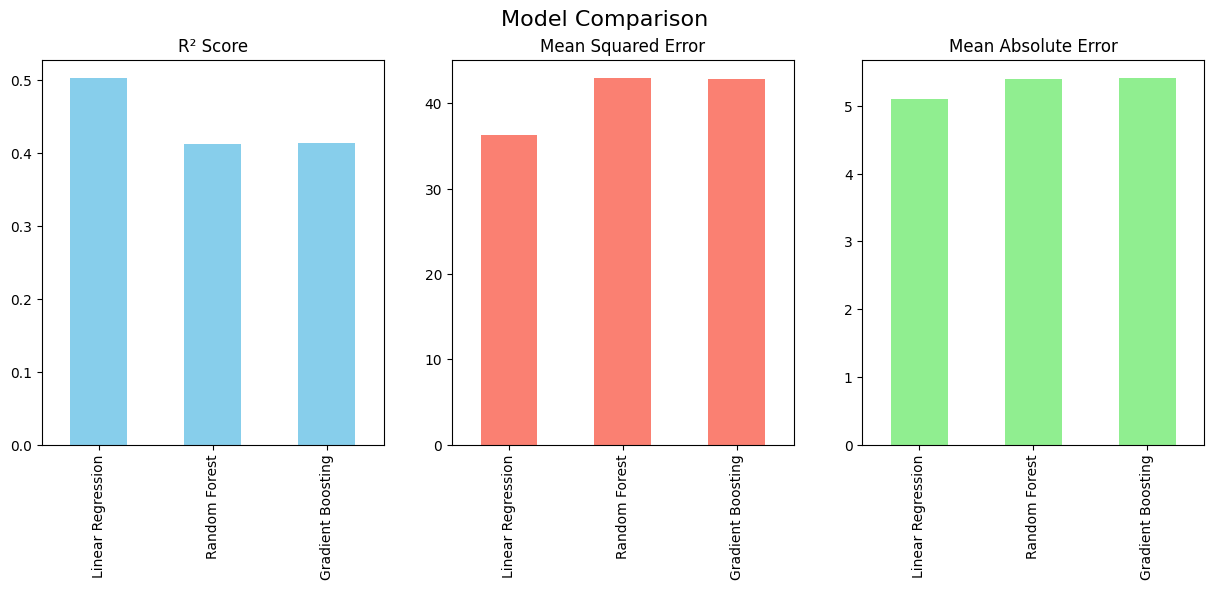


✅ Best Model: Linear Regression with R² = 0.5029


In [10]:
import matplotlib.pyplot as plt
import numpy as np

results = {}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred)
    }

import pandas as pd
results_df = pd.DataFrame(results).T

print("\nModel Performance:\n")
print(results_df)

fig, axes = plt.subplots(1, 3, figsize=(15,5))

results_df["R2"].plot(kind="bar", ax=axes[0], title="R² Score", color="skyblue")
results_df["MSE"].plot(kind="bar", ax=axes[1], title="Mean Squared Error", color="salmon")
results_df["MAE"].plot(kind="bar", ax=axes[2], title="Mean Absolute Error", color="lightgreen")

plt.suptitle("Model Comparison", fontsize=16)
plt.show()

best_model = results_df["R2"].idxmax()
best_score = results_df["R2"].max()

print(f"\n✅ Best Model: {best_model} with R² = {best_score:.4f}")
